In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set up data set for training
!wget https://www.changsiang.net/files/fundusv3.v4i.tensorflow.zip 

--2022-10-30 06:40:59--  https://www.changsiang.net/files/fundusv3.v4i.tensorflow.zip
Resolving www.changsiang.net (www.changsiang.net)... 104.21.42.249, 172.67.214.20, 2606:4700:3030::ac43:d614, ...
Connecting to www.changsiang.net (www.changsiang.net)|104.21.42.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9390817 (9.0M) [application/x-zip-compressed]
Saving to: ‘fundusv3.v4i.tensorflow.zip’

fundusv3.v4i.tensor 100%[===================>]   8.96M  2.96MB/s    in 3.0s    

2022-10-30 06:41:04 (2.96 MB/s) - ‘fundusv3.v4i.tensorflow.zip’ saved [9390817/9390817]



In [ ]:
!mkdir "./data"
!unzip fundusv3.v4i.tensorflow.zip -d "./data"

Archive:  fundusv3.v4i.tensorflow.zip
 extracting: ./data/README.dataset.txt  
 extracting: ./data/README.roboflow.txt  
   creating: ./data/train/
 extracting: ./data/train/_annotations.csv  
 extracting: ./data/train/eye_001_visit_1_image_1_png.rf.b779098b53f579b3091dd75505ee34e9.jpg  
 extracting: ./data/train/eye_001_visit_1_image_2_png.rf.606dc387afb5c31e232f6f47c5fbd1cd.jpg  
 extracting: ./data/train/eye_001_visit_1_image_4_png.rf.48f3662e95a189c5594ad5846facf1c2.jpg  
 extracting: ./data/train/eye_001_visit_2_image_1_png.rf.cea62bb56a145dcb45bdb7e8e27223fe.jpg  
 extracting: ./data/train/eye_001_visit_2_image_3_png.rf.7f14f6491e3e95a00d45a44746993386.jpg  
 extracting: ./data/train/eye_001_visit_2_image_4_png.rf.f23b530c19c750c909dcc0c1958f538c.jpg  
 extracting: ./data/train/eye_002_visit_1_image_1_png.rf.17d2837cd841124e9b2381665e94ec01.jpg  
 extracting: ./data/train/eye_002_visit_1_image_2_png.rf.09985689f7d06f5bad02980409c570ab.jpg  
 extracting: ./data/train/eye_002_visit

In [ ]:
# First.. get ResNet50 for free

model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None
)

# Freeze the ResNet50 layer
model.trainable = False

94765736/94765736 [==============================] - 2s 0us/step


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

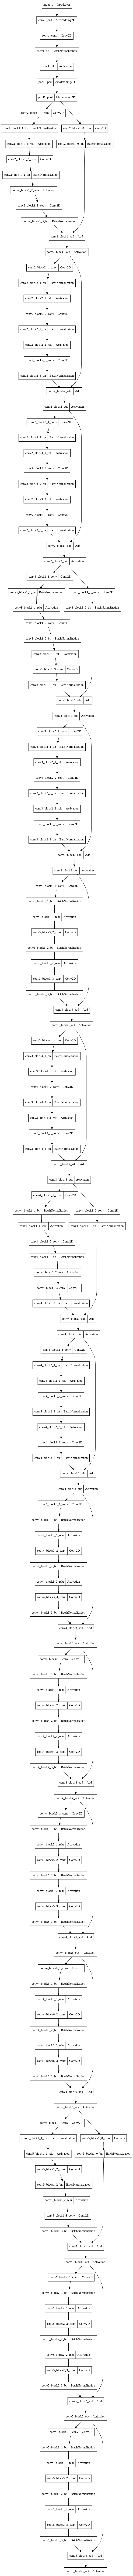

In [ ]:
# premodified model
model.summary()
plot_model(model)

In [ ]:
# Then, I customize the input layer and add 1 more convlution to
# match may expected output
input = Input(shape=(512, 512, 3), name='image_input')
x = model(input)


x = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, None, None,   23587712    ['image_input[0][0]']            
                                2048)                                                             
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   589856      ['resnet50[0][0]']               
                                                                                              

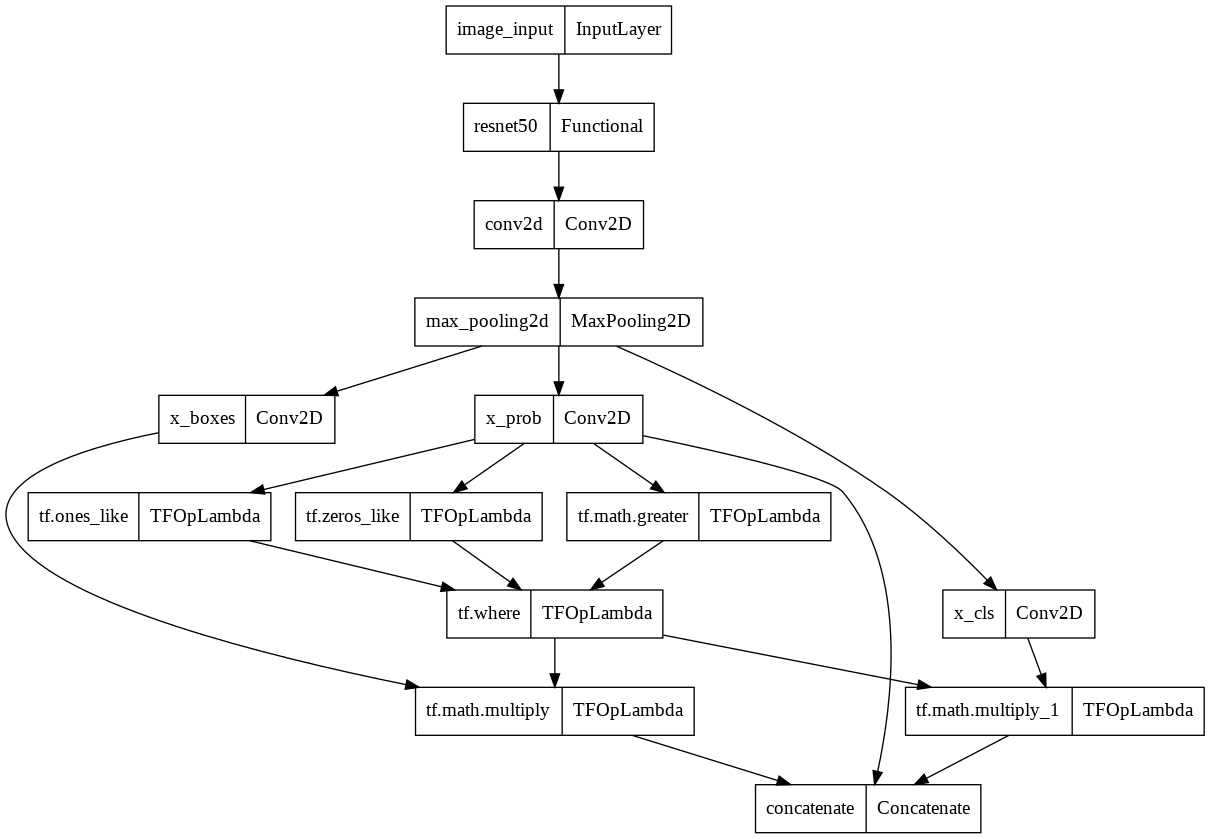

In [ ]:
# I customized the top to give me 3 information, class, probability, boxes: [x1, y1, x2, y2]
x_prob = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
x_cls = layers.Conv2D(4, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x)

# ---

gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate
x_cls = x_cls * gate

# ---

x = layers.Concatenate()([x_prob, x_boxes, x_cls])
model = tf.keras.models.Model(input, x)

# inspect and visualize the model
model.summary()
plot_model(model)

In [ ]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]
idx_cls = [5, 6, 7, 8]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss=loss_func, optimizer=opt)

In [ ]:
# Some helper methods to help with visualization
grid_size = 64 # 8x8 = 64

def get_color_by_probability(p):
    if p < 0.3:
        return (255., 0., 0.)
    if p < 0.7:
        return (255., 255., 0.)
    return (0., 255., 0.)

def show_predict(X, y, threshold=0.1):
    X = X.copy()
    for mx in range(8):
        for my in range(8):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]
            # print(f"channel: {channels}")

            # if prob < threshold we won't show any thing
            if prob < threshold:
                continue
            color = get_color_by_probability(prob)
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), color, 1)
            
            # label
            cv2.rectangle(X, (int(px), int(py - 40)), (int(px + 48), int(py)), color, -1)
            kls = np.argmax(channels[5:])
            cv2.putText(X, f'{kls}', (int(px + 2), int(py-2)), cv2.FONT_HERSHEY_PLAIN, 4.0, (0.0, 0.0, 0.0))

    plt.imshow(X)

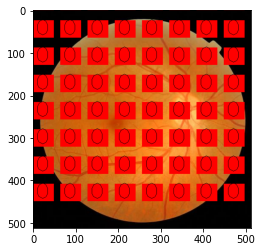

In [ ]:
def make_number(size=64):
  img = cv2.imread('./data/train/eye_013_visit_2_image_4_png.rf.06ce145796d458a1c945175da8dd394e.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  X = cv2.resize(img, (512, 512))
  y = np.zeros((64, 8, 8, 15), dtype=np.float32)
  return X, y

X, y = make_number()
show_predict(X, y[0], threshold=0)

1/1 [==============================] - 8s 8s/step


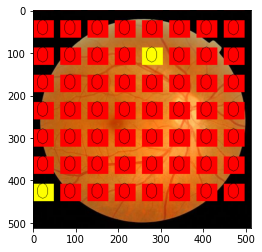

In [ ]:
def preview(numbers=None, threshold=0.1):
    X, y = make_number()
    X = X.reshape((1, 512, 512, 3))
    y = model.predict(X)
    show_predict(X[0], y[0], threshold=0)
preview()

In [ ]:
annotations = pd.read_csv("./data/train/_annotations.csv")
annotations

,filename,width,height,class,xmin,ymin,xmax,ymax
0,eye_013_visit_2_image_4_png.rf.06ce145796d458a...,512,512,fovea,184,252,215,283
1,eye_013_visit_2_image_4_png.rf.06ce145796d458a...,512,512,optic cup,342,223,364,246
2,eye_053_visit_2_image_4_png.rf.01b915887de669c...,512,512,optic cup,151,238,172,257
3,eye_052_visit_2_image_4_png.rf.06776fd1db041f8...,512,512,fovea,16,246,58,290
4,eye_005_visit_1_image_4_png.rf.078e4e75ade5d70...,512,512,fovea,23,256,44,276
...,...,...,...,...,...,...,...,...
1115,eye_053_visit_2_image_1_png.rf.ffa3814e81ba717...,512,512,fovea,179,258,222,295
1116,eye_053_visit_2_image_1_png.rf.ffa3814e81ba717...,512,512,optic cup,344,247,369,270
1117,eye_066_visit_2_image_4_png.rf.f8ccf55979f3821...,512,512,fovea,15,267,51,304
1118,eye_083_visit_2_image_1_png.rf.9539c86545a2a0f...,512,512,fovea,184,244,220,285


In [ ]:
cls_one_hot = pd.get_dummies(annotations['class'])
joined_df = annotations.join(cls_one_hot)
joined_df = joined_df.drop(['width', 'height', 'class'], axis=1)
joined_df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)


In [ ]:
joined_df


,filename,xmin,ymin,xmax,ymax,dot hemorrhage,drusen,fovea,optic cup
0,eye_013_visit_2_image_4_png.rf.06ce145796d458a...,184,252,215,283,0,0,1,0
1,eye_013_visit_2_image_4_png.rf.06ce145796d458a...,342,223,364,246,0,0,0,1
2,eye_053_visit_2_image_4_png.rf.01b915887de669c...,151,238,172,257,0,0,0,1
3,eye_052_visit_2_image_4_png.rf.06776fd1db041f8...,16,246,58,290,0,0,1,0
4,eye_005_visit_1_image_4_png.rf.078e4e75ade5d70...,23,256,44,276,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1115,eye_053_visit_2_image_1_png.rf.ffa3814e81ba717...,179,258,222,295,0,0,1,0
1116,eye_053_visit_2_image_1_png.rf.ffa3814e81ba717...,344,247,369,270,0,0,0,1
1117,eye_066_visit_2_image_4_png.rf.f8ccf55979f3821...,15,267,51,304,0,0,1,0
1118,eye_083_visit_2_image_1_png.rf.9539c86545a2a0f...,184,244,220,285,0,0,1,0


In [ ]:
len(joined_df.index)

1120

In [ ]:
grid_size = 16

def prep_datarow(X, y, file, target_y):
  X_img = cv2.imread(file)
  X = cv2.cvtColor(X_img, cv2.COLOR_BGR2RGB)
  for index, row in target_y.iterrows():
    # target_y should be [xmin, ymin, xmax, ymax, cls_1, cls_2, cls_3, cls_4, ...]
    bbox_x1 = row[1]
    bbox_y1 = row[2]
    bbox_x2 = row[3]
    bbox_y2 = row[4]
    cls = row[5:]

    mx, my = (bbox_x2 - bbox_x1) // grid_size, (bbox_y2 - bbox_y1) // grid_size
    channels = y[my][mx]

    if channels[0] > 0:
      continue
    
    channels[0] = 1.0
    channels[1] = bbox_x1
    channels[2] = bbox_x2
    channels[3] = bbox_y1
    channels[4] = bbox_y2
    channels[5:] = cls

In [ ]:
def make_dataset(dataset):
  unique_files = np.unique(dataset['filename'])
  X = np.zeros((len(unique_files), 512, 512, 3), dtype=np.float32)
  y = np.zeros((len(unique_files), 8, 8, 9), dtype=np.float32)
  for index, file in enumerate(unique_files):
    target_y = dataset.loc[dataset['filename'] == file]
    img_folder = "./data/train/"
    prep_datarow(X[index], y[index], f"{img_folder}{file}", target_y)
  return X, y

X, y = make_dataset(joined_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
history = model.fit(X_train, y_train, batch_size=5, epochs=300, shuffle=True)

Epoch 1/1000
72/72 [==============================] - 7s 97ms/step - loss: 86439.4375
Epoch 2/1000
72/72 [==============================] - 6s 86ms/step - loss: 85451.3516
Epoch 3/1000
72/72 [==============================] - 6s 86ms/step - loss: 86102.2891
Epoch 4/1000
72/72 [==============================] - 6s 86ms/step - loss: 85766.4453
Epoch 5/1000
72/72 [==============================] - 6s 86ms/step - loss: 85598.4219
Epoch 6/1000
72/72 [==============================] - 6s 86ms/step - loss: 85989.1094
Epoch 7/1000
72/72 [==============================] - 6s 86ms/step - loss: 86487.8594
Epoch 8/1000
72/72 [==============================] - 6s 86ms/step - loss: 86587.9062
Epoch 9/1000
72/72 [==============================] - 6s 85ms/step - loss: 86143.0469
Epoch 10/1000
72/72 [==============================] - 6s 85ms/step - loss: 85930.5391
Epoch 11/1000
72/72 [==============================] - 6s 85ms/step - loss: 86442.1562
Epoch 12/1000
72/72 [==============================]

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 22ms/step
[[[ 5.439763e-33  0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 0.000000e+00  0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00  0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00  0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00  0.000000e+00
    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00]
  [ 2.430634e-32 

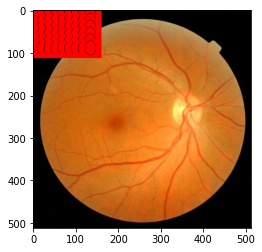

In [ ]:
def preview(numbers=None, threshold=0.1):
    X, y = make_number()
    X = X.reshape((1, 512, 512, 3))
    y = model.predict(X)
    print(y[0])
    show_predict(X[0], y[0], threshold=0)
preview()

In [ ]:
import pickle
pickle.dump(history, open('./training_history.pickle', 'wb'))
pickle.dump(model, open('./trained_model_resnet50.pickle', 'wb'))

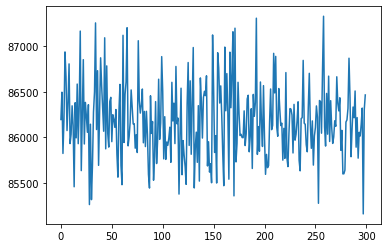

In [ ]:
loss = history.history['loss']
plt.plot(loss)

cp: cannot create regular file '/content/gdrive/My Drive': No such file or directory
cp: cannot create regular file '/content/gdrive/My Drive': No such file or directory
